# A tutorial presentation of HUROT: an Homogeneous Unbalanced Regularized Optimal Transport model

This tutorial will be completed over time. Any feedback or suggestion is welcome!

## Main ideas

Non-regularized (un)balanced Optimal Transport (OT) is defined as the following optimization 
problem:

$$ \mathrm{OT}_{\varphi}(\alpha,\beta) = \min_\pi \iint c(x,y) \mathrm{d}\pi + D_\varphi(\pi_1|\alpha) + D_\varphi(\pi_2|\beta), $$

where $c$ is the cost function of our problem (in the current implementation $c(x,y) = \|x-y\|^2$, other costs will be 
added in the future), and $D_\varphi$ is a divergence to the marginal (e.g. the Kullback-Leibler divergence) which 
depends on the choice of an entropy function $\varphi$. 

This problem is **homogeneous** with respect to the couple of input measures $(\alpha,\beta)$, that is

$$ \mathrm{OT}_{\varphi}(\lambda \alpha, \lambda \beta) = \lambda \cdot \mathrm{OT}_{\varphi}(\alpha,\beta), $$

and (probably more importantly) if $\pi$ is a optimal for the couple $(\alpha,\beta)$, then $\lambda \pi$ is optimal for 
the couple $(\lambda \alpha,\lambda \beta)$. 
This is a suitable behavior: rescaling the measures (e.g. changing the unit of measurment) should not change the 
structure of the solutions.

However, adding the celebrated entropic regularization term $+\epsilon \mathrm{KL}(\pi | \alpha \otimes \beta)$ 
may break homogeneity in some situations. 
Interestingly, when considering either
- Balanced optimal transport ($D_\varphi(\mu | \nu) = 0$ if $\mu=\nu$, $+\infty$ otherwise),
- KL divergence to the marginal ($D_\varphi = \mathrm{KL}$)

the objective value $\mathrm{OT}_{\epsilon,\varphi}$ is **not** homogeneous, but the optimal transport plans are 
homogeneous: the sturcture of the solutions is preserved. 
Furthermore, the so-called Sinkhorn divergence is also homogeneous. 

This does not hold for more general divergences though. For instance, using $D_\varphi = \mathrm{TV}$ the *Total Variation* 
yields inhomogeneity. 
This is even worse when considering spatially varying divergences as the one appearing in Optimal Transport with Boundary. 

## Bringing back homogeneity

In this repository, we propose a model of regularized (unbalanced) OT that will be homogeneous. 
The key idea is to slighly modify the entropic regularization term. 
We propose two formulations, using: 

$$ +\frac{\epsilon}{2} \left( \mathrm{KL}\left(\pi | \frac{\alpha}{m(\alpha)} \otimes \beta \right) + \mathrm{KL}\left(\pi | \alpha \otimes \frac{\beta}{m(\beta)} \right) \right) $$

or, somewhat more simply:

$$ +\epsilon \mathrm{KL}\left(\pi | \frac{\alpha \otimes \beta}{\sqrt{m(\alpha)m(\beta)}} \right).$$

These models are referred to as *harmonic* and *geometric* homogeneizations as they respectively involve 
the harmonic and the geometric means of the masses $m(\alpha),m(\beta)$ in the computations. 
They correspond to setting `mode_homogeneity="harmonic"` or `"geometric"` in the implementation. 
Setting `mode_homogeneity="std"` retrieves the standard (non-homogeneous) Unbalanced Regularized OT model. 

These models are homogeneous by construction, in particular the corresponding Sinkhorn divergences are positive. 

**Note:** In the reference paper, only the harmonic regularization has been studied in depth. 
Actually, the two models are very similar, the harmonic one presents the advantage of yielding a Sinkhorn divergence 
that does not need the introduction of a mass bias term. 

## Other options available

- Our implementation was motivated by applications in Topological Data Analysis (TDA). The metrics used in TDA can be 
cast as problems of *Optimal Transport with Boundary*, a model proposed by Figalli and Gigli. 
This model correspond to an Unbalanced OT problem involving a *spatially varying* marginal divergence. 
Adding the standard entropic regularization term (`mode_homogeneity="std"`) to this problem yields highly inhomogeneous 
behavior, suggesting that using an homogeneous entropic penalty (e.g. `mode_homogeneity="harmonic"`) is much more reliable.
This mode is available through the option `mode_divergence="boundary"`. 
For now, it is restricted to the case where the space is the open half plane $\Omega = \{(t_1,t_2),\ t_1 < t_2\} \subset \mathbb{R}^2$ 
and its boundary is thus the diagonal $\partial \Omega = \{(t,t),\ t \in \mathbb{R}\}$ (the situation of interest in TDA). 
Other implementation will be provided in the future. 
- We propose an option `corrected_marginals`. 
Setting this parameter to `True` changes the marginal terms $D_\varphi(\pi_1 | \alpha)$ and $D_\varphi(\pi_2 | \beta)$ 
to $D_\varphi\left(\pi_1 | \alpha \sqrt{\frac{m(\beta)}{m(\alpha)}}\right)$ and 
$D_\varphi\left(\pi_2 | \beta \sqrt{\frac{m(\alpha)}{m(\beta)}}\right)$ 
respectively. 
The idea being that, in any case, if $\alpha$ and $\beta$ have different total masses, it is pointless to expect the 
marginals $\pi_1,\pi_2$ of $\pi$ to equal $\alpha$ and $\beta$ ($\pi_1$ and $\pi_2$ have the same total masses). 
Thus, the standard marginals constraints are somewhat "in contradiction", and it may be interesting to replace them by 
more feasible constraints: the measures proposed above have the same total mass, namely $\sqrt{m(\alpha)m(\beta)}$. 

**Note:** The `corrected_marginals` approach has not been detailed in the reference paper. Actually, when `mode_homogeneity="geometric"`, it is very similar to compute 
$\sqrt{m(\alpha) m(\beta)} \cdot \mathrm{OT}_{\epsilon,\varphi}\left(\frac{\alpha}{m(\alpha)}, \frac{\beta}{m(\beta)} \right)$. 

### Run the quickstart

In [38]:
import numpy as np
from utils import sk_div, hurot

np.random.seed(1)

# Define the measures as weights + locations.
n, m = 5, 7
a = np.random.rand(n)
b = np.random.rand(m)
x = np.random.randn(n, 2)
y = np.random.randn(m, 2) + np.array([.5,.5])

# Set the parameter for the OT cost and the Sinkhorn divergence:
mode_divergence = "TV"  # To use the total variation as the marginal divergence.
mode_homogeneity = "harmonic"  # To use the harmonic 
eps = 1  # the entropic regularization parameter

value = sk_div(x, y, a, b, 
               mode_divergence  = mode_divergence, 
               mode_homogeneity = mode_homogeneity,
               corrected_marginals = False,
               eps = eps, 
               verbose=0, init="unif", 
               nb_step=1000, crit=0., stab=True)

P, f, g, ot_value = hurot(x, y, a, b,
                                mode_divergence=mode_divergence,
                                mode_homogeneity=mode_homogeneity,
                                corrected_marginals=False,
                                eps=eps,
                                verbose=0, init="unif",
                                nb_step=1000, crit=0., stab=True)

In [39]:
print("The sinkhorn divergence is:\n", value)

The sinkhorn divergence is:
 2.4869735115425264


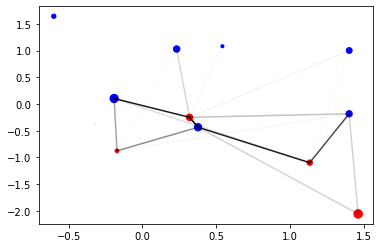

In [40]:
import matplotlib.pyplot as plt
from utils import plot_transport_plan
fig, ax = plt.subplots()
plot_transport_plan(ax=ax, xs=x, xt=y, P=P)
ax.scatter(x[:,0], x[:,1], marker='o', s=100*a, c='red')
ax.scatter(y[:,0], y[:,1], marker='o', s=100*b, c='blue')

Now let see what happens if we rescale the weights by $\lambda = 1000$.

In [41]:
P2 = hurot(x, y, 1000*a, 1000*b,
          mode_divergence=mode_divergence,
          mode_homogeneity=mode_homogeneity,
          corrected_marginals=False,
          eps=eps,
          verbose=0, init="unif",
          nb_step=1000, crit=0., stab=True)[0]

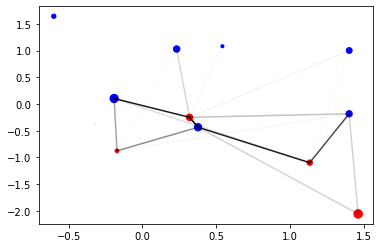

In [42]:
fig, ax = plt.subplots()
plot_transport_plan(ax=ax, xs=x, xt=y, P=P2)
ax.scatter(x[:,0], x[:,1], marker='o', s=100*a, c='red')
ax.scatter(y[:,0], y[:,1], marker='o', s=100*b, c='blue')

As we used `mode_homogeneity="harmonic"`, the transport plan is unchanged visually (it has only been rescaled by $1000$).

What happen if we use the standard model?

In [43]:
mode_homogeneity_2 = "std"

P3 = hurot(x, y, a, b,
          mode_divergence=mode_divergence,
          mode_homogeneity=mode_homogeneity_2,
          corrected_marginals=False,
          eps=eps,
          verbose=0, init="unif",
          nb_step=1000, crit=0., stab=True)[0]

P4 = hurot(x, y, 1000*a, 1000*b,
          mode_divergence=mode_divergence,
          mode_homogeneity=mode_homogeneity_2,
          corrected_marginals=False,
          eps=eps,
          verbose=0, init="unif",
          nb_step=1000, crit=0., stab=True)[0]

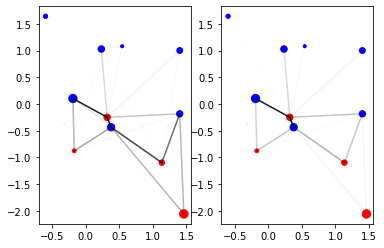

In [44]:
fig, axs = plt.subplots(1, 2)
ax = axs[0]
plot_transport_plan(ax=ax, xs=x, xt=y, P=P3)
ax.scatter(x[:,0], x[:,1], marker='o', s=100*a, c='red')
ax.scatter(y[:,0], y[:,1], marker='o', s=100*b, c='blue')

ax = axs[1]
plot_transport_plan(ax=ax, xs=x, xt=y, P=P4)
ax.scatter(x[:,0], x[:,1], marker='o', s=100*a, c='red')
ax.scatter(y[:,0], y[:,1], marker='o', s=100*b, c='blue')

As one can see, the transport plan are not proportional to each other (for instance, some mass on the bottom-right point is not transported when $\lambda = 1000$ but is transported for $\lambda = 1$). 

Inhomogeneity alters the _interpolation_ described by the optimal transport plans.